In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import mycolorbars


In [38]:
# Read in the other products
#nclu=NetCDFFile('rcp45_9100_oxid.nc','r')
nclu=NetCDFFile('/data/jain1/c/sshu3/SBGC/data/CONUS_CH4/fw_frac_max.nc','r')
ncvar_fw = nclu.variables['FW'][0,:,:]#+nclu.variables['ch4_flux_inund'][:]
latnc = nclu.variables['Lat'][:]
lonnc = nclu.variables['Lon'][:]
# lonnc = ((lonnc - 180) % 360) - 180
nclu.close()

nclu_fw=NetCDFFile('/data/jain1/c/sshu3/SBGC/data/CONUS_CH4/ISAM_HYDE_LANDCOVER_1980.nc','r')
#nclu3=NetCDFFile('rcp45_soiloxid.nc','r')
ncvar_lc = nclu_fw.variables['AREAVEG'][:]#+nclu.variables['ch4_flux_inund'][:]
nclu_fw.close()

# Mask out regions outside the CONUS
ncmk=NetCDFFile('surfdata_05x05_13reg.nc','r')
ncvar_mask = ncmk.variables['REGION_MASK_CRU_NCEP'][:]
ncmk.close()

#ncvar_net = ncvar_net*ncvar_mask
#ncvar2_net = ncvar2_net*ncvar_mask
#ncvar3_net = ncvar3_net*ncvar_mask
ncvar_fw[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_fw[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask

ncvar_for  = ncvar_lc[0,:,:]+ncvar_lc[1,:,:]+ncvar_lc[2,:,:]+ncvar_lc[3,:,:]+ncvar_lc[4,:,:]+ncvar_lc[5,:,:] \
         + ncvar_lc[6,:,:]#+ncvar_lc[14,:,:]+ncvar_lc[15,:,:]+ncvar_lc[16,:,:]+ncvar_lc[17,:,:]+ncvar_lc[18,:,:]+ncvar_lc[19,:,:] \
#         + ncvar_lc[20,:,:]
ncvar_crop = ncvar_lc[22,:,:]+ncvar_lc[23,:,:]
ncvar_herb = 100-ncvar_crop-ncvar_for

ncvar_for[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_for[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_crop[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_crop[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_herb[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
ncvar_herb[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask


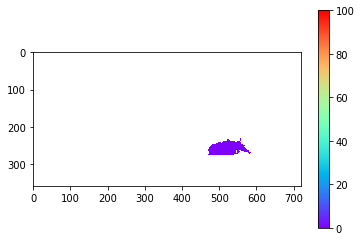

In [30]:
plt.imshow(ncvar_fw, cmap='rainbow',vmin=0, vmax=100)
plt.colorbar()

In [39]:
np.nansum(ncvar_for*ncvar_fw)

1183.5687815867518

In [42]:
np.nansum(ncvar_herb*ncvar_fw)

12333.898806436875

In [41]:
np.nansum(ncvar_crop*ncvar_fw)

5241.559347936806

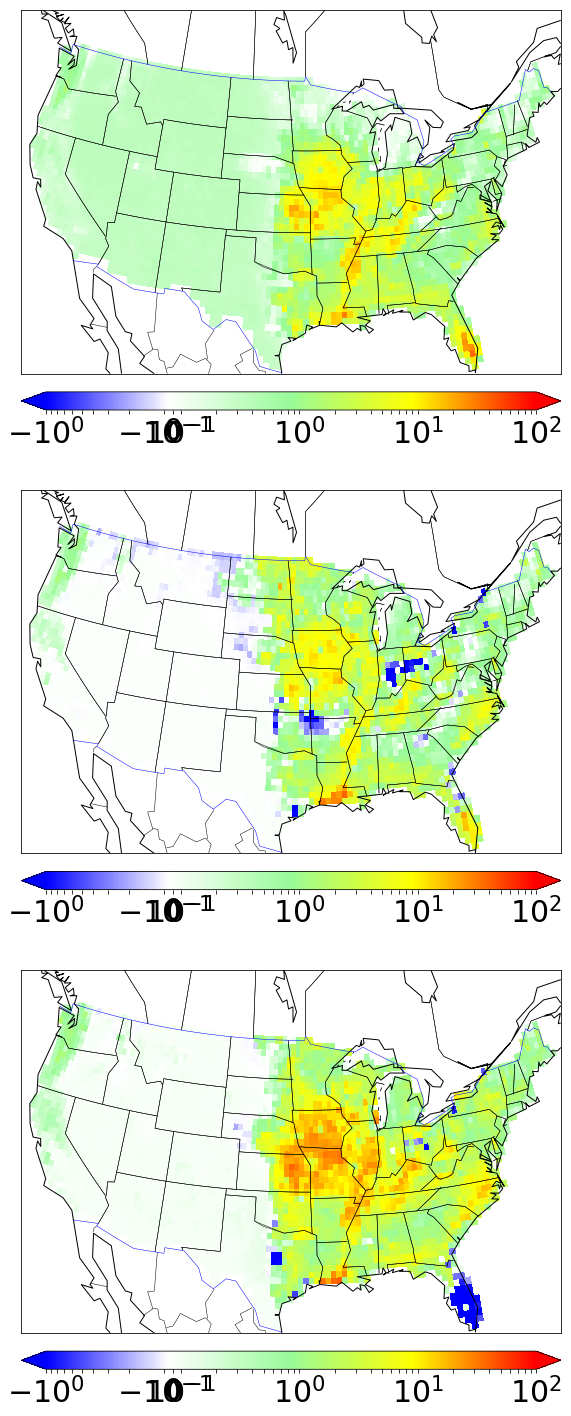

In [54]:
#http://matplotlib.org/basemap/users/mapsetup.html

# My personal colormap
# (1) Modified color bar from cm.jet
#my_cmap = mycolorbars.color_ch4emission()
# (2) Self-craeted color bar
colors_dict = [(0,0,255), (255,255,255), (152,251,152), (255,255,0), (255,0,0)] # This example uses the 8-bit RGB
my_cmap = mycolorbars.make_cmap(colors_dict, bit=True)

fig = plt.figure(figsize=(15,25))

#ax1 = fig.add_subplot(221)
ax1 = fig.add_subplot(311)
#ax1.set_title("Net $CH_4$ flux (gC-$CH_4$/$m^2$/yr) ",fontsize=20)
#ax1.set_title("$CH_4$ Oxidation flux (gC-$CH_4$/$m^2$/yr) ",fontsize=20)
#ax1.set_title("$CH_4$ Production (gC-$CH_4$/$m^2$/yr)",fontsize=20)
#ax1.set_title("$CH_4$ Aerenchyma transport (gC-$CH_4$/$m^2$/yr)",fontsize=20)
#ax1.set_title("$CH_4$ Ebullition (gC-$CH_4$/$m^2$/yr)",fontsize=20)
#ax1.set_title("$CH_4$ Diffusion (gC-$CH_4$/$m^2$/yr)",fontsize=20)

map = Basemap(llcrnrlon=-119,llcrnrlat=23,urcrnrlon=-63,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,ncvar_oxid[:,:],
              norm=colors.SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-1.0, vmax=100),cmap=my_cmap) # use log color scale,                   
#              norm=colors.LogNorm(vmin=0.01, vmax=100),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cs1.cmap.set_under('w')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
#plt.title('Maize harvested area fraction')
cbar.ax.tick_params(labelsize=30) 

ax1 = fig.add_subplot(312)
#ax1.set_title("Net $CH_4$ flux (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)
#ax1.set_title("$CH_4$ Oxidation (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)
#ax1.set_title("$CH_4$ Production (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)
#ax1.set_title("$CH_4$ Aerenchyma transport (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)
#ax1.set_title("$CH_4$ Ebullition (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)
#ax1.set_title("$CH_4$ Diffusion (gC-$CH_4$/$m^2$/yr) RCP4.5",fontsize=20)

map = Basemap(llcrnrlon=-119,llcrnrlat=23,urcrnrlon=-63,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,ncvar2_oxid[:,:] - ncvar_oxid[:,:],
              norm=colors.SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-1.0, vmax=100.0),cmap=my_cmap) # use log color scale,
#              norm=colors.LogNorm(vmin=0.01, vmax=100),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cs.cmap.set_under('w')
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=30) 

ax1 = fig.add_subplot(313)
#ax1.set_title("Net $CH_4$ flux (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)
#ax1.set_title("$CH_4$ Oxidation (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)
#ax1.set_title("$CH_4$ Production (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)
#ax1.set_title("$CH_4$ Aerenchyma transport (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)
#ax1.set_title("$CH_4$ Ebullition (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)
#ax1.set_title("$CH_4$ Diffusion (gC-$CH_4$/$m^2$/yr) RCP8.5",fontsize=20)

map = Basemap(llcrnrlon=-119,llcrnrlat=23,urcrnrlon=-63,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,ncvar3_oxid[:,:] - ncvar_oxid[:,:],
norm=colors.SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-1.0, vmax=100.0),cmap=my_cmap) # use log color scale,
#              norm=colors.LogNorm(vmin=0.01, vmax=100),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cs.cmap.set_under('w')
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=30) 

#plt.show()
plt.savefig('Onw_CH4.jpg',dpi=400)

In [ ]:
### An example of how to use make_cmap
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(311)
### Create a list of RGB tuples
colors = [(255,0,0), (255,255,0), (255,255,255), (0,157,0), (0,0,255)] # This example uses the 8-bit RGB
### Call the function make_cmap which returns your colormap
my_cmap = make_cmap(colors, bit=True)
### Use your colormap
plt.pcolor(np.random.rand(25,50), cmap=my_cmap)
plt.colorbar()

ax = fig.add_subplot(312)
colors = [(1,1,1), (0.5,0,0)] # This example uses the arithmetic RGB
### If you are only going to use your colormap once you can
### take out a step.
plt.pcolor(np.random.rand(25,50), cmap=make_cmap(colors))
plt.colorbar()

ax = fig.add_subplot(313)
colors = [(0.4,0.2,0.0), (1,1,1), (0,0.3,0.4)]
### Create an array or list of positions from 0 to 1.
position = [0, 0.3, 1]
plt.pcolor(np.random.rand(25,50), cmap=make_cmap(colors, position=position))
plt.colorbar()

plt.savefig("custom_cmap.png")
plt.show()

In [ ]:
plt.imshow(np.random.rand(10,10),cmap=cm.copper)
plt.show()